In [157]:
import pandas as pd 
import numpy as np 

# bayesian 
import pymc as pm 

# visualizations
import seaborn as sns 

# pickle 
import pickle

In [60]:
# starting small -- using the 2022 combined grad rate dataset 

data = pd.read_csv('data/2022_NYS_grad-rate.csv',dtype={'entity_cd':'string'})
data

,entity_cd,entity_name,year,subgroup_name,grad_rate
0,010100010034,Albany High School,2022,Hispanic or Latino,73.7
1,010100010034,Albany High School,2022,White,86.9
2,010100010034,Albany High School,2022,Multiracial,77.4
3,010100010034,Albany High School,2022,English Language Learner,70.4
4,010100010034,Albany High School,2022,Economically Disadvantaged,75.5
...,...,...,...,...,...
4675,671501040002,Warsaw Senior High School,2022,Economically Disadvantaged,88.1
4676,680601060001,Penn Yan Academy,2022,White,91.1
4677,680601060001,Penn Yan Academy,2022,Economically Disadvantaged,88.6
4678,680801040001,Dundee Junior-Senior High School,2022,White,78.6


In [7]:
data.grad_rate.describe()

count    4680.000000
mean       85.097436
std        14.369245
min         0.000000
25%        79.500000
50%        89.100000
75%        95.300000
max       100.000000
Name: grad_rate, dtype: float64

<Axes: xlabel='grad_rate', ylabel='Count'>

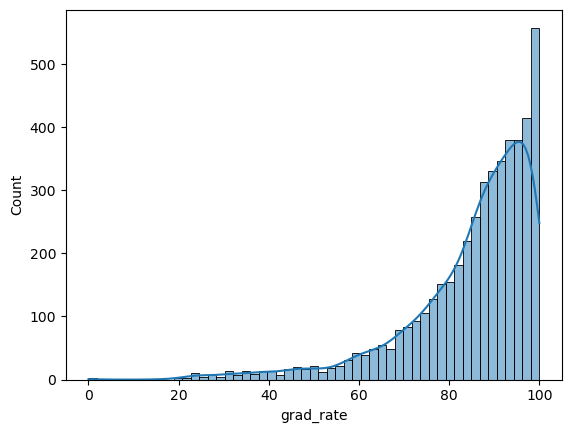

In [5]:
sns.histplot(data, x='grad_rate',kde=True)

In [8]:
data

,entity_cd,entity_name,year,subgroup_name,grad_rate
3161,342700861147,New Dawn Charter Hs Ii,2022,Economically Disadvantaged,0.0
3162,342700861147,New Dawn Charter Hs Ii,2022,Black or African American,0.0


In [14]:
# prereqs 
schools = data.entity_name.unique() 
n_schools = len(schools)
school_lookup = dict(zip(schools, range(n_schools)))

In [17]:
school = data.entity_cd = data.entity_name.replace(school_lookup).values
grad_rate = data.grad_rate

In [27]:
nys_cats = pd.read_csv('raw data/GRAD_RATE_AND_OUTCOMES_2022.csv',usecols=
            ['subgroup_name','aggregation_code','aggregation_name','lea_beds','lea_name','nrc_code','nrc_desc','county_name','county_code'],
                       dtype=str)

In [28]:
# removing records that contain aggregated records that aren't useful 
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0000')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0001')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0002')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0003')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0004')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0005')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0006')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0007')]

# renaming columns 
nys_cats = nys_cats.rename(
    columns={'aggregation_code':'beds_cd','aggregation_name':'school','lea_name':'district'})

# normalizing str values 
nys_cats.school = nys_cats.school.str.title()
nys_cats.district = nys_cats.district.str.title()
nys_cats.county_name = nys_cats.county_name.str.title()
nys_cats = nys_cats.reset_index(drop=True)

In [69]:
county_lookup = nys_cats[['county_code','county_name']].drop_duplicates().reset_index(drop=True)
county_lookup = county_lookup.set_index('county_code')
county_lookup = county_lookup.to_dict()

In [143]:
county_lookup =  {'01': 'Albany',
                  '02': 'Allegany',
                  '03': 'Broome',
                  '04': 'Cattaraugus',
                  '05': 'Cayuga',
                  '06': 'Chautauqua',
                  '07': 'Chemung',
                  '08': 'Chenango',
                  '09': 'Clinton',
                  '10': 'Columbia',
                  '11': 'Cortland',
                  '12': 'Delaware',
                  '13': 'Dutchess',
                  '14': 'Erie',
                  '15': 'Essex',
                  '16': 'Franklin',
                  '17': 'Fulton',
                  '18': 'Genesee',
                  '19': 'Greene',
                  '20': 'Hamilton',
                  '21': 'Herkimer',
                  '22': 'Jefferson',
                  '23': 'Kings',
                  '24': 'Lewis',
                  '25': 'Madison',
                  '26': 'Monroe',
                  '27': 'Montgomery',
                  '28': 'Nassau',
                  '31': 'New York',
                  '32': 'Bronx',
                  '33': 'Kings',
                  '34': 'Queens',
                  '35': 'Richmond',
                  '40': 'Niagara',
                  '41': 'Oneida',
                  '42': 'Onondaga',
                  '43': 'Ontario',
                  '44': 'Orange',
                  '45': 'Orleans',
                  '46': 'Oswego',
                  '47': 'Otsego',
                  '48': 'Putnam',
                  '49': 'Rensselaer',
                  '50': 'Rockland',
                  '51': 'Saint Lawrence',
                  '52': 'Saratoga',
                  '53': 'Schenectady',
                  '54': 'Schoharie',
                  '55': 'Schuyler',
                  '56': 'Seneca',
                  '57': 'Steuben',
                  '58': 'Suffolk',
                  '59': 'Sullivan',
                  '60': 'Tioga',
                  '61': 'Tompkins',
                  '62': 'Ulster',
                  '63': 'Warren',
                  '64': 'Washington',
                  '65': 'Wayne',
                  '66': 'Westchester',
                  '67': 'Wyoming',
                  '68': 'Yates'}

In [160]:
#f = open('county_lookup.pkl','wb')
#pickle.dump(county_lookup,f)
#f.close()

In [144]:
data['county_code'] = data.entity_cd.str[:2]
data.county_code = data.county_code.map(county_lookup)
data = data.rename(columns={'county_code':'county'})

In [193]:
counties_gr = data.groupby('county')['grad_rate'].median().sort_values(ascending=True)

<Axes: ylabel='Proportion'>

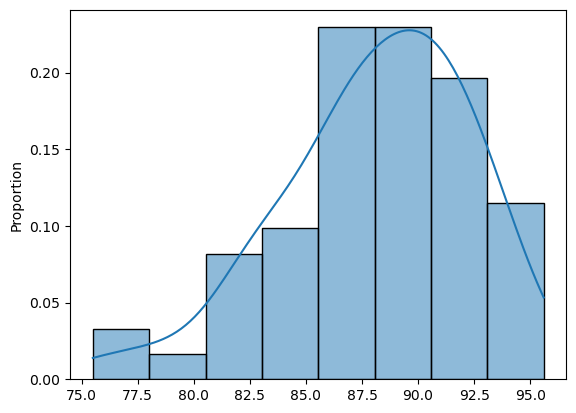

In [195]:
sns.histplot(counties_gr,x=counties_gr.values,stat='proportion',kde=True)

In [207]:
subgroup_list = data.subgroup_name.unique().tolist()
school_list = data.entity_name.unique().tolist()

In [235]:
district_lookup = nys_cats[nys_cats.school.isin(school_list)]
district_lookup

,beds_cd,school,lea_beds,district,nrc_code,nrc_desc,county_code,county_name,subgroup_name
0,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,All Students
1,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Male
2,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Female
3,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,General Education Students
4,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Students with Disabilities
...,...,...,...,...,...,...,...,...,...
82685,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Non-English Language Learner
82686,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not in Foster Care
82687,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not Homeless
82688,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not Migrant


In [236]:
district_lookup = district_lookup[['school','district']].drop_duplicates().reset_index(drop=True)
district_lookup = district_lookup.set_index('school')
district_lookup = district_lookup.to_dict()

In [243]:
district_lookup = district_lookup['district']

In [245]:
#f = open('district_lookup.pkl','wb')
#pickle.dump(district_lookup,f)
#f.close()